
# Demonstration of Proxy Discrimination and `DiscriminationMitigator`

In [ ]:
# standard preamble
import json
from DiscriminationMitigation import *
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
http://localhost:8888/notebooks/Documents/ML_Discrimination/ml-discrimination-mitigation/Demonstration_of_Proxy_Discrimination.ipynb#
with open('example_config.json') as j:
    config = json.load(j)
    
N = 8000


In the following data generating process, we have a target variable *y* that we are trying to predict, we have dummies for two categories of a protected class *c1* and *c0*, and we have covariates *w1*, ... .  
Class membership is drawn from a binomial.  
Covariates depend upon independent normal draws plus class category specific means.  Category specific means generate correlation between class category membership and covariates.  
The target variables *y* is determined by covariates, independent normal draws, and class category membership.  Class category membership causing y can be though of many ways. We find it most convenient to interpret it as representing unobserved causal variables that are correlated with protected class, but it could also represent bias in the target or taste-based discrimination in the target.  

In [215]:
def simple_synth(n=500, class_prob=0.5, 
                 gamma=np.matrix([[2,3],[.4,.6]]), 
                 alpha=np.matrix([[0,2]]), 
                 beta=np.matrix([[2,2],[1,1]]) ):
    
    np.random.seed(1776)

    # Protected class variable
    c1 = np.random.binomial(1, p=class_prob, size=n) # group 1
    c0 = 1-c1 # group 0

    # Other covariates
    w0 = gamma[0,0]*c0 + gamma[0,1]*c1 + np.random.normal(0, 0.5, size=n) # linear function of class & shock
    w1 = gamma[1,0]*c0 + gamma[1,1]*c1 + np.random.normal(0, 0.3, size=n)
                                                                 
    # Outcome variable
    y = alpha[0,0]*c0   + alpha[0,1]*c1 + \
        beta[0,0]*c0*w0 + beta[0,1]*c1*w0 + \
        beta[1,0]*c0*w1 + beta[1,1]*c1*w1 + \
        np.random.normal(0, 0.3, size=n)

    return pd.DataFrame([y, c0, c1, w0, w1]).T.rename(columns={0:'y', 1: 'c0', 2: 'c1', 3: 'w0', 4:'w1'})

#### Instantiate some synthetic data

In [238]:
class_prob=0.5
gamma=np.matrix([[2,3.5],[.4,.6]])
alpha=np.matrix([[0,2]])
beta=np.matrix([[2,2],[1,1]])
synth = simple_synth(n=N, class_prob=class_prob, gamma=gamma, alpha=alpha, beta=beta)
print(synth.head())
print("\n", synth.shape)

          y   c0   c1        w0        w1
0  4.673528  1.0  0.0  2.214135  0.324108
1  7.939870  0.0  1.0  2.404301  1.070192
2  5.222822  1.0  0.0  2.338783  0.519127
3  9.406248  0.0  1.0  3.145858  0.822292
4  3.990423  1.0  0.0  1.523643  0.897265

 (8000, 5)


#### Displaying the Problem

In [239]:
def dgp_y_hat(c0, c1, w0, w1, alpha, beta):
    y = alpha[0,0]*c0   + alpha[0,1]*c1 + \
        beta[0,0]*c0*w0 + beta[0,1]*c1*w0 + \
        beta[1,0]*c0*w1 + beta[1,1]*c1*w1
    return y
   
    
    

In [240]:
y_fit_test = dgp_y_hat(0.5, 0.5, 1.0, 0.5, alpha, beta)

# y_fit1 = synth.loc[:, "w0"].apply(lambda w0: dgp_y_hat(0.5, 0.5, w0, 0.5, alpha, beta), axis=0)
#print(y_fit_of_w0_c1(1))
print(y_fit_test)

3.5


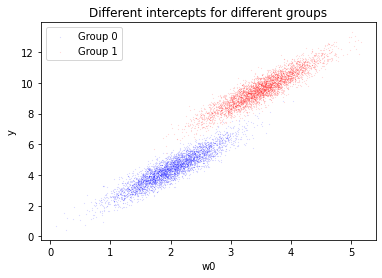

In [276]:
synth_vars = ["y", "c0", "c1", "w0", "w1"]
c0_data = synth.loc[synth.loc[:, "c0"] == 1, :]
c1_data = synth.loc[synth.loc[:, "c1"] == 1, :]

matplotlib.use('module://ipykernel.pylab.backend_inline')
fig, axs = plt.subplots(ncols=1)
axs.scatter(c0_data.loc[:, "w0"],c0_data.loc[:, "y"],color='blue', marker= '.', label='Group 0', s=0.01)
axs.scatter(c1_data.loc[:, "w0"],c1_data.loc[:, "y"],color= 'red', marker='.', label='Group 1', s=0.01)

axs.set_title('Different intercepts for different groups')
axs.set_xlabel('w0')
axs.set_ylabel('y')
axs.legend(loc='best')
#fig




**Discussion of above figure**

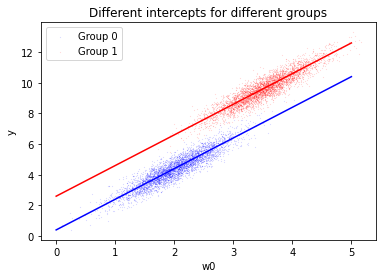

In [277]:
def y_fit_of_w0_of_c1(w0, c1):  #class_prob, alpha, beta, gamma)
    mean_w1 = (1-c1)*gamma[1,0] + c1*gamma[1,1]
    return dgp_y_hat(1-c1, c1, w0, mean_w1, alpha, beta)
#y_fit1 = synth.loc[:, "w0"].apply(lambda w0: dgp_y_hat(0.5, 0.5, w0, 0.5, alpha, beta), axis=0)
#y_fit_w0_c1 = synth.loc[:, "w0"].apply(lambda w0: y_fit_of_w0_of_c1(w0,1))
#y_fit_w0_c0 = synth.loc[:, "w0"].apply(lambda w0: y_fit_of_w0_of_c1(w0,0))


w0_space = np.linspace(0, 5, 20)
f_w0_c0 = lambda w0: y_fit_of_w0_of_c1(w0, 0)
f_w0_c1 = lambda w0: y_fit_of_w0_of_c1(w0, 1)
y_fitted_w0_c0 = f_w0_c0(w0_space)
y_fitted_w0_c1 = f_w0_c1(w0_space)

axs.plot(w0_space, y_fitted_w0_c0, color = "blue")
axs.plot(w0_space, y_fitted_w0_c1, color = "red")
fig
#ax = plt.plot(w0_space, y_fitted)
#ax.show()
#ax = plt.line()



#### What does the neural net predict when we omit the protected class variable? 

In [244]:
# Train (and val) / test split
X_train, X_test, y_train, y_test = train_test_split(synth.loc[:, ~synth.columns.isin(config['target_feature'] + ["c0", "c1"])],
                                                    synth[config['target_feature']], random_state=1776,
                                                    test_size=0.2)
# Train / val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=123, test_size=0.2)

for x in X_train, X_val, X_test:
    print(x.shape)

tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=2,))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

print(model.summary())


(5120, 2)
(1280, 2)
(1600, 2)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 913
Trainable params: 913
Non-trainable params: 0
____________________________

In [247]:
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/10
80/80 [==============================] - 0s 2ms/step - loss: 0.7616 - val_loss: 0.3980
Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.7829 - val_loss: 0.3917
Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.7721 - val_loss: 0.4541
Epoch 4/10
80/80 [==============================] - 0s 3ms/step - loss: 0.7560 - val_loss: 0.3962
Epoch 5/10
80/80 [==============================] - 0s 3ms/step - loss: 0.7359 - val_loss: 0.3893
Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.6998 - val_loss: 0.4014
Epoch 7/10
80/80 [==============================] - 0s 2ms/step - loss: 0.7385 - val_loss: 0.3953
Epoch 8/10
80/80 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.3918
Epoch 9/10
80/80 [==============================] - 0s 3ms/step - loss: 0.7152 - val_loss: 0.3891
Epoch 10/10
80/80 [==============================] - 0s 3ms/step - loss: 0.6871 - val_loss: 0.3960


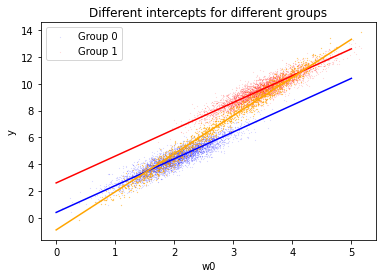

In [278]:

X_test_pseudo = X_test.copy()
w1_mean = (gamma[1,0] + gamma[1,1])/2
X_test_pseudo.loc[:,"w1"] = X_test.loc[:, "w1"] * 0 * w1_mean
y_test_hat__no_C = model.predict(X_test)
w0_test = X_test.loc[:, "w0"]

w0_space

y_train_hat__no_C = model.predict(X_train)
w0_train = X_train.loc[:, "w0"]

#fig, axs = plt.subplots(ncols=1)
#axs.plot(w0_space, y_fitted_w0_c0, color = "blue")
#axs.plot(w0_space, y_fitted_w0_c1, color = "red")

axs.scatter(w0_test, y_test_hat__no_C, color = "orange", marker= '.', label='prediction: class omited', s=.2)
#axs.scatter(w0_train, y_train_hat__no_C, color = "yellow", marker= 'o', label='prediction: class omited', s=1)



X_hypotheticals__to_draw_line = pd.DataFrame({"w0": w0_space, "w1": w0_space * 0 + w1_mean})
y_hypothetical = model.predict(X_hypotheticals__to_draw_line)
axs.plot(X_hypotheticals__to_draw_line.loc[:,"w0"], y_hypothetical, color="orange")
fig

#### Get example marginal weights

In [5]:
with open('example_weights.json') as j:
    weights = json.load(j)
print(weights)

{'z': {'1': 0.9, '2': 0.02, '3': 0.04, '4': 0.04}}


The parameter `weights` allows users to supply a dictionary of custom marginal distributions for each protected class feature. Suppose you'd like to put more weight on predictions that treated individuals as though they were members of value 1 in protected class feature 'z' -- say, if the weight on z=1 were 0.9, rather than ~0.25? You'd simply need to change the values in the weights dictionary. Importantly marginals per feature must sum to 1. Further, in this example, 'c0' and 'c1' are one-hot vectors for a binary random variable. In this case, if you altered the share of one group in 'c0' you'd also need to apply the inverse to 'c1' so that the marginals reflected mutual exclusivity. If `DiscriminationMitigator` detects two variables as possible one-hot vectors (i.e. they are extremely correlated), it will raise a Warning, but it *will not* enforce that the marginals of adjacent one-hot vectors are indeed inverses.

Additionally, JSON files require keys (in this case, feature names) to be strings, so make sure yours are. `DiscriminationMitigator` converts these to their correct numeric format, so you need not worry about this.

['y', 'c0', 'c1']

#### Train a Tensorflow Keras Sequential deep learning model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
X_train

,c0,c1,w0,w1
126,1.0,0.0,4.545620,-0.358214
358,0.0,1.0,5.329924,0.331814
355,1.0,0.0,3.812156,0.776741
533,0.0,1.0,5.803170,0.557149
450,1.0,0.0,3.887764,0.039358
...,...,...,...,...
706,1.0,0.0,4.145032,0.347784
409,0.0,1.0,5.520678,0.022376
65,0.0,1.0,7.083715,1.186667
265,1.0,0.0,4.567907,-0.094556


In [21]:
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
7/7 [==============================] - 0s 32ms/step - loss: 130.8063 - val_loss: 113.6633
Epoch 2/10
7/7 [==============================] - 0s 11ms/step - loss: 119.5574 - val_loss: 100.9304
Epoch 3/10
7/7 [==============================] - 0s 10ms/step - loss: 106.3023 - val_loss: 88.8536
Epoch 4/10
7/7 [==============================] - 0s 11ms/step - loss: 92.3370 - val_loss: 77.5663
Epoch 5/10
7/7 [==============================] - 0s 11ms/step - loss: 83.2960 - val_loss: 66.9398
Epoch 6/10
7/7 [==============================] - 0s 11ms/step - loss: 70.9145 - val_loss: 56.9766
Epoch 7/10
7/7 [==============================] - 0s 11ms/step - loss: 61.6633 - val_loss: 47.8046
Epoch 8/10
7/7 [==============================] - 0s 10ms/step - loss: 51.9673 - val_loss: 39.3636
Epoch 9/10
7/7 [==============================] - 0s 10ms/step - loss: 44.8063 - val_loss: 31.6701
Epoch 10/10
7/7 [==============================] - 0s 11ms/step - loss: 36.4944 - val_loss: 24.8560


## Discrimination mitigation tool

#### Example 1: Use just the marginals from `df`

In [9]:
ex1 = DiscriminationMitigator(df=X_test, model=model, config=config, train=None, weights=None).predictions()

In the following examples, unadjusted predictions (`unadj_pred`) and uniform weights (`unif_wts`) remain the same. Population weights (`pop_wts`) in this case pertain to the marginal distributions per protected class feature in `df`. 

In [11]:
print("Dataframe of predictions: \n", ex1.reset_index(drop=True).head())
print("\nStatistical moments: \n", ex1.describe())
print("\nCorrelation matrix of predictions: \n", ex1.corr())

Dataframe of predictions: 
    unadj_pred  unif_wts   pop_wts
0    6.746980  6.758377  6.767809
1    6.075054  6.103145  6.107012
2    5.917782  5.889691  5.885960
3    6.499167  6.521694  6.527415
4    6.741848  6.753245  6.762677

Statistical moments: 
        unadj_pred    unif_wts     pop_wts
count  500.000000  500.000000  500.000000
mean     6.191450    6.191427    6.191450
std      0.549065    0.565770    0.571420
min      4.960387    4.943426    4.935985
25%      5.721015    5.703740    5.695928
50%      6.198308    6.196548    6.198081
75%      6.657816    6.679993    6.685009
max      7.633538    7.650499    7.658076

Correlation matrix of predictions: 
             unadj_pred  unif_wts   pop_wts
unadj_pred    1.000000  0.999761  0.999663
unif_wts      0.999761  1.000000  0.999976
pop_wts       0.999663  0.999976  1.000000


#### Example 2: Use the marginals from another dataset (`train`)

In [12]:
ex2 = DiscriminationMitigator(df=X_test, model=model, config=config, train=X_train, weights=None).predictions()

In cases that the training set (or another dataset) is considerably larger and potentially more population representative than `df`, you may want to reweight the adjusted predictions in `pop_wts` to the marginals of all protected class features in this other dataset.

In [13]:
print("Dataframe of predictions: \n", ex2.reset_index(drop=True).head())
print("\nStatistical moments: \n", ex2.describe())
print("\nCorrelation matrix of predictions: \n", ex2.corr())

Dataframe of predictions: 
    unadj_pred  unif_wts   pop_wts
0    6.746980  6.758377  6.767430
1    6.075054  6.103145  6.106634
2    5.917782  5.889691  5.885582
3    6.499167  6.521694  6.527037
4    6.741848  6.753245  6.762299

Statistical moments: 
        unadj_pred    unif_wts     pop_wts
count  500.000000  500.000000  500.000000
mean     6.191450    6.191427    6.191072
std      0.549065    0.565770    0.571420
min      4.960387    4.943426    4.935606
25%      5.721015    5.703740    5.695550
50%      6.198308    6.196548    6.197703
75%      6.657816    6.679993    6.684631
max      7.633538    7.650499    7.657698

Correlation matrix of predictions: 
             unadj_pred  unif_wts   pop_wts
unadj_pred    1.000000  0.999761  0.999663
unif_wts      0.999761  1.000000  0.999976
pop_wts       0.999663  0.999976  1.000000


In [14]:
compare_pop = pd.concat([ex1['pop_wts'].rename('df'), ex2['pop_wts'].rename('train')], axis=1)
print("Compare population weights from 'df' vs. 'train':")
print(compare_pop.describe())

Compare population weights from 'df' vs. 'train':
               df       train
count  500.000000  500.000000
mean     6.191450    6.191072
std      0.571420    0.571420
min      4.935985    4.935606
25%      5.695928    5.695550
50%      6.198081    6.197703
75%      6.685009    6.684631
max      7.658076    7.657698


#### Example 3: Use the marginals from another dataset and use custom weights

In [15]:
ex3 = DiscriminationMitigator(df=X_test, model=model, config=config, train=X_train, weights=weights).predictions()


Warning! The following features are extremely correlated and thus may be one-hot vectors: c0 c1. 
If no category is omitted, users must ensure custom marginal weights for one-hot vectors align correctly.


You may also want to reweight predictions to ask 'what-if' questions: i.e. what if the share of group *x* were different than their observed share in the data? Providing a dictionary of marginal distributions to `weights` will allow for this.

In [18]:
print("Custom weights:", weights, "\n")
print("Dataframe of predictions: \n", ex3.reset_index(drop=True).head())
print("\nStatistical moments: \n", ex3.describe())
print("\nCorrelation matrix of predictions: \n", ex3.corr())

Custom weights: {'z': {'1': 0.9, '2': 0.02, '3': 0.04, '4': 0.04}} 

Dataframe of predictions: 
    unadj_pred  unif_wts   pop_wts  cust_wts
0    6.746980  6.758377  6.767430  6.744531
1    6.075054  6.103145  6.106634  6.105993
2    5.917782  5.889691  5.885582  5.915334
3    6.499167  6.521694  6.527037  6.518977
4    6.741848  6.753245  6.762299  6.739400

Statistical moments: 
        unadj_pred    unif_wts     pop_wts    cust_wts
count  500.000000  500.000000  500.000000  500.000000
mean     6.191450    6.191427    6.191072    6.205807
std      0.549065    0.565770    0.571420    0.548989
min      4.960387    4.943426    4.935606    4.980197
25%      5.721015    5.703740    5.695550    5.741638
50%      6.198308    6.196548    6.197703    6.206755
75%      6.657816    6.679993    6.684631    6.681364
max      7.633538    7.650499    7.657698    7.642218

Correlation matrix of predictions: 
             unadj_pred  unif_wts   pop_wts  cust_wts
unadj_pred    1.000000  0.999761  0.99

#### Example 4: Reweighting multiple features at onece - possible, but to be avoided!

In [19]:
new_weights = {'c0': {0.0: 0.1, 1.0: 0.9}, 'c1': {0.0: 0.9, 1.0: 0.1}, 'z': {1.0: 0.9, 2.0: 0.02, 3.0: 0.04, 4.0: 0.04}}
ex4 = DiscriminationMitigator(df=X_test, model=model, config=config, train=X_train, weights=new_weights).predictions()


Warning! The following features are extremely correlated and thus may be one-hot vectors: c0 c1. 
If no category is omitted, users must ensure custom marginal weights for one-hot vectors align correctly.


JOE: I don't understand what you are getting at here.  

Though `DiscriminationMitigator` does not forbid it, we discourage users from reweighting multiple protected class features at the same time. The reason being that this attenuates the effect of the individual reweighted protected class feature. Each reweighted feature produces an *N* x 1 vector, so the preceding creates 3 counterfactual vectors, which are then averaged across for each person. Though the marginals may be weighted differently, this averaging may produce very similar predictions between `pop_wts` and `cust_wts` and should be hence avoided.

In [17]:
print("Custom weights:", new_weights, "\n")
print("Dataframe of predictions: \n", ex4.reset_index(drop=True).head())
print("\nStatistical moments: \n", ex4.describe())
print("\nCorrelation matrix of predictions: \n", ex4.corr())

Custom weights: {'c0': {0.0: 0.1, 1.0: 0.9}, 'c1': {0.0: 0.9, 1.0: 0.1}, 'z': {1.0: 0.9, 2.0: 0.02, 3.0: 0.04, 4.0: 0.04}} 

Dataframe of predictions: 
    unadj_pred  unif_wts   pop_wts  cust_wts
0    6.661998  6.676531  6.654327  6.601067
1    6.271629  6.202929  6.208470  6.155210
2    5.450657  5.519357  5.515208  5.461948
3    6.695879  6.654924  6.651216  6.597956
4    6.580443  6.594976  6.572772  6.519513

Statistical moments: 
        unadj_pred    unif_wts     pop_wts    cust_wts
count  500.000000  500.000000  500.000000  500.000000
mean     6.141468    6.141298    6.142123    6.088863
std      0.559403    0.533642    0.526824    0.526824
min      4.807796    4.876495    4.872347    4.819087
25%      5.643587    5.679643    5.691246    5.637986
50%      6.155550    6.154496    6.149170    6.095911
75%      6.611161    6.593558    6.573488    6.520228
max      7.422514    7.353815    7.359354    7.306095

Correlation matrix of predictions: 
             unadj_pred  unif_wts   